#### Introduction
This notebook examines single-family loan data from Freddie Mac, mortgages originating from 2005-2012. Compares two different classification algorithms, random forest and logistic regression, to model & predict mortgage delinquencies. 

In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import display
pd.options.mode.chained_assignment = None

We incorporate average interest rates, for short-term and long-term mortgages, into the dataframe. 

In [3]:
prim15 = pd.read_csv('data/primary15yr.txt', delimiter = '\t')
new_index = []
for date in prim15['Date']:
    new_date = date[-4:]+date[:2]
    new_index.append(new_date)
prim15 = prim15.assign(date=new_index)
prim15['date'] = prim15['date'].astype(int)
prim15 = prim15.drop('Date', axis=1)
prim15.set_index('date', inplace=True)

prim30 = pd.read_csv('data/primary30yr.txt', delimiter = '\t')
new_index = []
for date in prim30['Date']:
    new_date = date[-4:]+date[:2]
    new_index.append(new_date)
prim30 = prim30.assign(date=new_index)
prim30['date'] = prim30['date'].astype(int)
prim30 = prim30.drop('Date', axis=1)
prim30.set_index('date', inplace=True)

In [7]:
df_raw = pd.read_csv('data/primary15yr.txt', delimiter = '\t')

In [17]:
df_raw.index = map(lambda x: x[-4:] + date[:2], df_raw["Date"])

In [19]:
df_raw.index.astype(int)

Int64Index([199106, 199106, 199106, 199106, 199206, 199206, 199206, 199206,
            199206, 199206,
            ...
            201606, 201606, 201606, 201606, 201706, 201706, 201706, 201706,
            201706, 201706],
           dtype='int64', length=310)

In [15]:
map(lambda x: x[-4:] + date[:2], df_raw["Date"])

['199106',
 '199106',
 '199106',
 '199106',
 '199206',
 '199206',
 '199206',
 '199206',
 '199206',
 '199206',
 '199206',
 '199206',
 '199206',
 '199206',
 '199206',
 '199206',
 '199306',
 '199306',
 '199306',
 '199306',
 '199306',
 '199306',
 '199306',
 '199306',
 '199306',
 '199306',
 '199306',
 '199306',
 '199406',
 '199406',
 '199406',
 '199406',
 '199406',
 '199406',
 '199406',
 '199406',
 '199406',
 '199406',
 '199406',
 '199406',
 '199506',
 '199506',
 '199506',
 '199506',
 '199506',
 '199506',
 '199506',
 '199506',
 '199506',
 '199506',
 '199506',
 '199506',
 '199606',
 '199606',
 '199606',
 '199606',
 '199606',
 '199606',
 '199606',
 '199606',
 '199606',
 '199606',
 '199606',
 '199606',
 '199706',
 '199706',
 '199706',
 '199706',
 '199706',
 '199706',
 '199706',
 '199706',
 '199706',
 '199706',
 '199706',
 '199706',
 '199806',
 '199806',
 '199806',
 '199806',
 '199806',
 '199806',
 '199806',
 '199806',
 '199806',
 '199806',
 '199806',
 '199806',
 '199906',
 '199906',
 '199906',

In [5]:
prim15.head()

,Rate (Avg)
date,
199109,9.244
199110,9.044
199111,8.853
199112,8.593
199201,8.533


This is an index of housing prices by state. For Guam, Puerto Rico, the Virgin Islands, etc., we assume the national average. 

In [3]:
state_hpi = pd.read_csv('state_hbi.csv')
state_hpis= state_hpi.loc[312:]
state_hpis.loc[:,'Date'] = state_hpis.apply(lambda x: x.loc['Date'][3:] + x.loc['Date'][:2], axis=1)
#state_hpi_06.loc[:,'Date'] = state_hpi_06.apply(lambda x: x.loc['Date'][3:] + x.loc['Date'][:2], axis=1)
state_hpis.Date=state_hpis.Date.astype(int, copy=False)
state_hpis.set_index('Date', inplace = True)
#for loans in Guam,Puerto Rico, & the Virgin Islands, I set 'state' hpi to national levels. 
state_hpis.head()

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
Date,,,,,,,,,,,,,,,,,,,,,
200101,138.20,143.95,142.28,157.16,126.56,221.67,119.00,138.14,123.42,142.26,...,148.04,144.30,195.76,133.37,145.6,125.21,156.73,167.79,139.55,168.38
200102,139.44,144.43,142.86,157.73,127.90,224.24,119.54,141.16,124.34,143.37,...,148.43,144.77,196.62,134.60,146.3,124.80,157.78,168.37,141.00,167.17
200103,141.25,145.17,143.17,159.02,129.54,225.97,121.31,143.22,124.93,144.74,...,148.88,145.84,197.42,136.19,147.6,128.02,158.59,169.88,140.32,169.26
200104,143.07,145.91,143.48,160.32,131.18,227.70,123.08,145.28,125.52,146.11,...,149.33,146.90,198.23,137.79,148.9,131.24,159.40,171.38,139.64,171.35
200105,144.88,146.65,143.79,161.61,132.82,229.43,124.85,147.34,126.11,147.48,...,149.79,147.97,199.04,139.39,150.3,134.46,160.21,172.89,138.96,173.45


In [4]:
state_hpas = pd.DataFrame(index = state_hpis.index)
for column in state_hpis.columns:
    old = state_hpis[column]
    shifted = old.shift(1)
    new = old / shifted
    state_hpas[column] = new
state_hpas.loc[200101] = 1
state_hpas.head()

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
Date,,,,,,,,,,,,,,,,,,,,,
200101,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
200102,1.008973,1.003334,1.004076,1.003627,1.010588,1.011594,1.004538,1.021862,1.007454,1.007803,...,1.002634,1.003257,1.004393,1.009222,1.004808,0.996726,1.006699,1.003457,1.010391,0.992814
200103,1.012980,1.005124,1.002170,1.008179,1.012823,1.007715,1.014807,1.014593,1.004745,1.009556,...,1.003032,1.007391,1.004069,1.011813,1.008886,1.025801,1.005134,1.008968,0.995177,1.012502
200104,1.012885,1.005097,1.002165,1.008175,1.012660,1.007656,1.014591,1.014383,1.004723,1.009465,...,1.003023,1.007268,1.004103,1.011748,1.008808,1.025152,1.005108,1.008830,0.995154,1.012348
200105,1.012651,1.005072,1.002161,1.008046,1.012502,1.007598,1.014381,1.014180,1.004700,1.009376,...,1.003080,1.007284,1.004086,1.011612,1.009402,1.024535,1.005082,1.008811,0.995130,1.012256


In [5]:
#unzips the state hpa data
index = state_hpas.index
lyst = []
for state in state_hpas.columns:
    series1 = state_hpas[state]
    series1.name='hpa'
    series2 = pd.Series(state, index=index)
    series2.name = 'state'
    frame = pd.concat([series1, series2], axis=1)
    lyst.append(frame)
state_hpas = pd.concat(lyst)
state_hpas.head()

,hpa,state
Date,,
200101,1.000000,AK
200102,1.008973,AK
200103,1.012980,AK
200104,1.012885,AK
200105,1.012651,AK


In [6]:
#multi index magic
tuples = zip(state_hpas.index,state_hpas.state.values)
index1 = pd.MultiIndex.from_tuples(tuples, names = ['first payment date', 'property state'])
index2 = pd.MultiIndex.from_tuples(tuples, names = ['monthly reporting period', 'property state'])
s_multi_orig = pd.Series(state_hpas.hpa.values, index = index1, name='original hpa')
s_multi_mp = pd.Series(state_hpas.hpa.values, index = index2, name = 'current hpa')

In [7]:
state_uer = pd.read_csv('state_uer.csv')
months = {'JAN':1,'FEB':2,'MAR':3,'APR':4,'MAY':5,'JUN':6,'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}
state_uer['month'] = state_uer.Mnth.map(months)
state_uer['Date'] = 100*state_uer['DataYear'].values + state_uer['month'].values
state_uer.set_index('Date', inplace=True)
state_uer.head()

,State,Mnth,DataYear,UnemploymentRate,month
Date,,,,,
199001,AK,JAN,1990,8.5,1
199002,AK,FEB,1990,8.6,2
199003,AK,MAR,1990,8.2,3
199004,AK,APR,1990,7.6,4
199005,AK,MAY,1990,7.2,5


In [8]:
uer = pd.read_csv('UnemploymentHistory.txt', delimiter = "\t")
uer.loc[:,'Date'] = uer.apply(lambda x: x.loc['Date'][3:] + x.loc['Date'][:2], axis=1)
uer.Date = uer.Date.astype(int, copy=False)
uer.set_index('Date', inplace=True)
uer.head()

,Unemployment
Date,
198301,10.4
198302,10.4
198303,10.3
198304,10.2
198305,10.1


In [9]:
temp_index = []
for year in range(1990,2018):
    for month in range(1,13):
        mrp = year*100 + month
        temp_index.append(mrp)
        if mrp == 201705:
            break
temp_index = np.array(temp_index)

In [10]:
states = state_uer.State.unique()
state_uer_long = pd.DataFrame(index = temp_index, columns = states)
for mrp in temp_index:
    mrp_slice = state_uer.loc[mrp]
    for state in states:
        state_slice = mrp_slice.loc[mrp_slice['State']==state]
        state_uer_long.loc[mrp,state] = state_slice.UnemploymentRate.values[0]
state_uer_long.head()

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
199001,8.5,6.9,7.5,5.6,5.7,6.2,5.3,5.5,4.6,5.9,...,4.6,5.6,6.6,4.8,4.5,5.2,6.3,5.1,8.8,6.9
199002,8.6,7.5,7.5,5.3,5.6,5.9,5.3,5.7,4.4,5.7,...,4.4,5.5,6.6,5,4.2,5.3,6.5,5.2,8.9,6.6
199003,8.2,6.8,7,5.1,5.4,5.8,5,5.8,4,5.5,...,4.4,4.9,6.2,4.7,3.9,5.4,5.8,5.1,8,6.3
199004,7.6,6.3,6.7,5.1,5.4,5.2,4.9,5.6,3.7,5.7,...,3.8,5.2,6.1,4.5,3.7,5.3,5.1,4.3,7.8,5.5
199005,7.2,6.2,6.7,5.1,5.2,5.1,5,6,3.4,5.7,...,3.8,5,6.2,4.4,4,4.8,5,3.8,7.7,4.9


In [11]:
us_colonies = ['VI','PR','GU']
for colony in us_colonies:
    state_uer_long[colony] = uer['Unemployment']
state_uer_long.head()
                           

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,TX,UT,VA,VT,WA,WI,WV,WY,VI,GU
199001,8.5,6.9,7.5,5.6,5.7,6.2,5.3,5.5,4.6,5.9,...,6.6,4.8,4.5,5.2,6.3,5.1,8.8,6.9,5.4,5.4
199002,8.6,7.5,7.5,5.3,5.6,5.9,5.3,5.7,4.4,5.7,...,6.6,5,4.2,5.3,6.5,5.2,8.9,6.6,5.3,5.3
199003,8.2,6.8,7,5.1,5.4,5.8,5,5.8,4,5.5,...,6.2,4.7,3.9,5.4,5.8,5.1,8,6.3,5.2,5.2
199004,7.6,6.3,6.7,5.1,5.4,5.2,4.9,5.6,3.7,5.7,...,6.1,4.5,3.7,5.3,5.1,4.3,7.8,5.5,5.4,5.4
199005,7.2,6.2,6.7,5.1,5.2,5.1,5,6,3.4,5.7,...,6.2,4.4,4,4.8,5,3.8,7.7,4.9,5.4,5.4


In [12]:
index = state_uer_long.index
lyst = []
for state in state_uer_long.columns:
    series1 = state_uer_long[state]
    series1.name='uer'
    series2 = pd.Series(state, index=index)
    series2.name = 'state'
    frame = pd.concat([series1, series2], axis=1)
    lyst.append(frame)
state_uer = pd.concat(lyst)
state_uer.head()

,uer,state
199001,8.5,AK
199002,8.6,AK
199003,8.2,AK
199004,7.6,AK
199005,7.2,AK


In [13]:
tuples = zip(state_uer.index,state_uer.state.values)
index1 = pd.MultiIndex.from_tuples(tuples,names = ['monthly reporting period','property state'])
u_multi = pd.Series(state_uer.uer.values,index=index1,name='unemployment')

In [14]:
u_multi.head()

monthly reporting period  property state
199001                    AK                8.5
199002                    AK                8.6
199003                    AK                8.2
199004                    AK                7.6
199005                    AK                7.2
Name: unemployment, dtype: object

In [15]:
hpi_and_uer = pd.concat([s_multi_mp,u_multi], axis=1)

National unemployment rate. 

In [16]:
def cleaner(year):
    odf = pd.read_csv('samples/sample_orig_%i.txt'%year, delimiter = '|', header = None, na_values='   ', 
                      usecols = [0,1,5,8,10,16,18,19,20,21], names = ['credit score','first payment date','mi %','original cltv','original upb', 'property state','postal code', 'loan sequence number', 'loan purpose','original loan term'])
    odf['>300?'] = np.where(odf['original loan term']>300, True, False)
    odf = odf.join(s_multi_orig, how='left', on=['first payment date', 'property state'])
    mpdf = pd.read_csv('samples/sample_svcg_%i.txt'%year, delimiter = '|', header = None, usecols = [0,1,2,3,4,10], 
                       na_values =['R','XX', '   ', '  '], names = ['loan sequence number', 'monthly reporting period', 'current actual upb', 'current loan delinquency status', 'loan age', 'current interest rate'])
    mpdf = mpdf.assign(del_lead = mpdf['current loan delinquency status'].shift(-1))
    mpdf = mpdf.assign(delinquent = mpdf['del_lead'] >1.0)
    #we consider a mortgage to be delinquent when the payment is 60 or more days behind schedule. 
    mpdf = mpdf.loc[mpdf['current loan delinquency status'].isin([0,1])]
    #this step restricts our consideration to current loans
    #thus the 'delinquent' variable indicates a loan transitioning from current to delinquent in the next month. 
    df = mpdf.join(odf.set_index('loan sequence number'), on=('loan sequence number'), how='left')
    longs = df.loc[df['>300?']]
    longs = longs.merge(prim30, how='left', left_on='monthly reporting period', right_index=True)
    shorts = df.loc[~df['>300?']]
    shorts = shorts.merge(prim15, how='left', left_on='monthly reporting period', right_index=True)
    df = pd.concat([longs, shorts])
    df = df.join(s_multi_mp, how='left', on=['monthly reporting period', 'property state'])
    df = df.join(u_multi, how='left', on=['monthly reporting period', 'property state'])
    return df

In [18]:
liszt = []
for i in range(2005,2013):
    frame = cleaner(i)
    liszt.append(frame)

In [19]:
delinquency_percent_by_vintage = {}
for i in range(8):
    year = 2005+i
    rate = liszt[i].delinquent.astype(int).mean()
    a_rate = rate*12*100
    delinquency_percent_by_vintage[year] = a_rate
delinquency_percent_by_vintage

{2005: 4.511254797551952,
 2006: 6.935527031905699,
 2007: 8.410648928480667,
 2008: 5.812298233665583,
 2009: 1.0212614264661666,
 2010: 0.7230691387625104,
 2011: 0.574533110738059,
 2012: 0.24776016218387692}

In [20]:
df = pd.concat(liszt)

In [21]:
df['present year'] = df['monthly reporting period'].values/100

In [22]:
df['present year'].value_counts()

2012    2440245
2011    2374610
2010    2213674
2013    2127713
2009    2030140
2014    1824836
2008    1767635
2015    1606144
2007    1306049
2016    1281824
2006     801899
2005     255625
Name: present year, dtype: int64

Let's take a look at what the dataframe looks like. 

In [27]:
df.head(10)

,loan sequence number,monthly reporting period,current actual upb,current loan delinquency status,loan age,current interest rate,del_lead,delinquent,credit score,first payment date,...,property state,postal code,loan purpose,original loan term,>300?,original hpa,Rate (Avg),current hpa,unemployment,present year
0,F105Q1000064,200503,62000.00,0.0,0,5.75,0.0,False,722.0,200504,...,WA,98200.0,P,360,True,1.02052,6.105,1.020950,6,2005
1,F105Q1000064,200504,62000.00,0.0,1,5.75,0.0,False,722.0,200504,...,WA,98200.0,P,360,True,1.02052,6.010,1.020520,5.5,2005
2,F105Q1000064,200505,62000.00,0.0,2,5.75,0.0,False,722.0,200504,...,WA,98200.0,P,360,True,1.02052,5.870,1.020107,5.4,2005
3,F105Q1000064,200506,62000.00,0.0,3,5.75,0.0,False,722.0,200504,...,WA,98200.0,P,360,True,1.02052,5.730,1.017330,5.5,2005
4,F105Q1000064,200507,62000.00,0.0,4,5.75,0.0,False,722.0,200504,...,WA,98200.0,P,360,True,1.02052,5.833,1.017078,5.3,2005
5,F105Q1000064,200508,62000.00,0.0,5,5.75,0.0,False,722.0,200504,...,WA,98200.0,P,360,True,1.02052,5.953,1.016791,5.3,2005
6,F105Q1000064,200509,61000.00,0.0,6,5.75,0.0,False,722.0,200504,...,WA,98200.0,P,360,True,1.02052,5.920,1.005952,5.2,2005
7,F105Q1000064,200510,61419.22,0.0,7,5.75,0.0,False,722.0,200504,...,WA,98200.0,P,360,True,1.02052,6.203,1.005875,4.9,2005
8,F105Q1000064,200511,61352.55,0.0,8,5.75,0.0,False,722.0,200504,...,WA,98200.0,P,360,True,1.02052,6.480,1.005882,5.4,2005
9,F105Q1000064,200512,61285.56,0.0,9,5.75,0.0,False,722.0,200504,...,WA,98200.0,P,360,True,1.02052,6.405,1.011160,5.1,2005


In [45]:
df.columns

Index([u'loan sequence number', u'monthly reporting period',
       u'current actual upb', u'current loan delinquency status', u'loan age',
       u'current interest rate', u'del_lead', u'delinquent', u'credit score',
       u'first payment date', u'mi %', u'original cltv', u'original upb',
       u'property state', u'postal code', u'loan purpose',
       u'original loan term', u'>300?', u'original hpa', u'Rate (Avg)',
       u'current hpa', u'unemployment', u'present year', u'zip region'],
      dtype='object')

Its length is just over 20 million rows. I have found that adding more years' worth of mortgage data to this notebook begins to critically overload the code's searching and selection capabilities, suggesting some upper-limit to how large a dataframe a 'casual' implementation supports. Of course, a dataframe with mixed datatypes (especially strings) is more taxing on processing speed. And splitting an even larger dataframe into smaller pieces provides a workaround. 

The avg. yearly delinquency rates by year.

In [28]:
delinquency_percent_per_annum = []
for i in range(2005, 2017):
    slyce = df.loc[df['present year']==i]
    rate = slyce.delinquent.astype(int).mean()
    a_rate = 100*(1-(1-rate)**12)
    delinquency_percent_per_annum.append(a_rate)
annum_key = {}
for i in range(0,12):
    year = 2005+i
    annum_key[year] = delinquency_percent_per_annum[i]
annum_key

{2005: 0.771828209308778,
 2006: 1.0647286778550868,
 2007: 1.9125113053031995,
 2008: 3.6948321226777714,
 2009: 6.313376476088539,
 2010: 5.271154698128722,
 2011: 4.114185329333586,
 2012: 3.2836112820197716,
 2013: 3.1327222350745254,
 2014: 3.02362769086425,
 2015: 2.8533856491696596,
 2016: 2.9421871252138354}

In [29]:
import matplotlib.pyplot as plt

Note: By multiplying the quarterly probability of delinquency by 3, we obtain a (rather good) estimate of the quarterly rate 'proper' (analogous to the compound interest calculation).  

In [30]:
delinquency_percent_per_quarter = []
for i in range(2005, 2017):
    l = []
    for j in range(1,13):
        mrp = 100*i + j
        slyce = df.loc[df['monthly reporting period']==mrp]
        rate = slyce.delinquent.astype(int).mean()
        a_rate = 100*rate
        l.append(a_rate)
    for k in range(0,4):
        b = 3*k
        q_rate = 3*(np.mean(l[b:b+3]))
        delinquency_percent_per_quarter.append(q_rate)

In [31]:
quarter_key = {}
for i in range(12):
    year = str(i + 2005)
    for j in range(4):
        quarter = 'Q' + str(j+1)
        index = i+j
        name = year+quarter
        quarter_key[name] = delinquency_percent_per_quarter[i+j]    

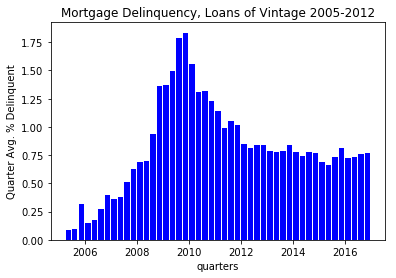

In [32]:
a_ran = np.arange(2005,2017,0.25)
plt.bar(a_ran, delinquency_percent_per_quarter, color='b', align='edge', width=0.2)
plt.ylabel('Quarter Avg. % Delinquent')
plt.title('Mortgage Delinquency, Loans of Vintage 2005-2012')
plt.xlabel('quarters')
plt.show()

Seems plausible. Observe the local spike at the end of 2005--this is the effect of Hurricane Katrina. 

We plot out some macroeconomic trends. 

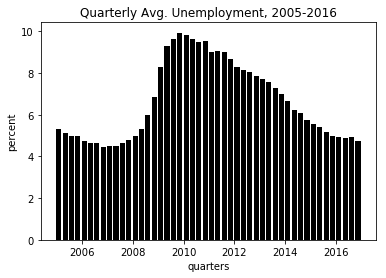

In [33]:
quarter_avg_uer = []
for i in range(2005, 2017):
    l = []
    for j in range(1,13):
        mrp = 100*i + j
        unemp = uer.loc[mrp, 'Unemployment']
        l.append(unemp)
    for k in range(0,4):
        b = 3*k
        q_uer = (np.mean(l[b:b+3]))
        quarter_avg_uer.append(q_uer)
a_ran = np.arange(2005,2017,0.25)
plt.bar(a_ran, quarter_avg_uer, color='k', align='edge', width=0.2)
plt.title('Quarterly Avg. Unemployment, 2005-2016')
plt.ylabel('percent')
plt.xlabel('quarters')
plt.show()

The period of peak unemployment coincides with the period of peak delinquency. Recall that the delinquency data here is perhaps artificially low in the first two years. 

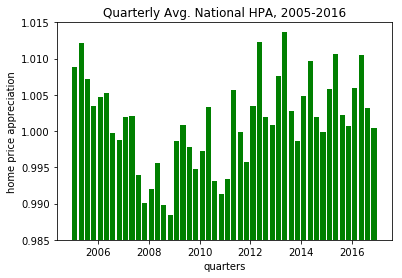

In [34]:
national_hpa = state_hpas.loc[state_hpas.state=='VI']
quarter_avg_hpa = []
for i in range(2005, 2017):
    l = []
    for j in range(1,13):
        mrp = 100*i + j
        hpa = national_hpa.loc[mrp, 'hpa']
        l.append(hpa)
    for k in range(0,4):
        b = 3*k
        q_hpa = (np.mean(l[b:b+3]))
        quarter_avg_hpa.append(q_hpa)
a_ran = np.arange(2005,2017,0.25)
plt.bar(a_ran, quarter_avg_hpa, color='g', align='edge', width=0.2)
plt.title('Quarterly Avg. National HPA, 2005-2016')
plt.ylim(0.985,1.015)
plt.ylabel('home price appreciation')
plt.xlabel('quarters')
plt.show()

What if we modify the data slightly? Instead of plotting HPA, we plot *depreciation.* (Take one minus quarterly average HPA.) 

What is the relationship between loan age and delinquency, hmm?

In [39]:
del_by_age = []
bin_count = []
for i in range(0,100):
    age_slice = df.loc[df['loan age']==i]
    bin_count.append(len(age_slice))
    rate = age_slice.delinquent.astype(int).mean()
    del_by_age.append(rate)

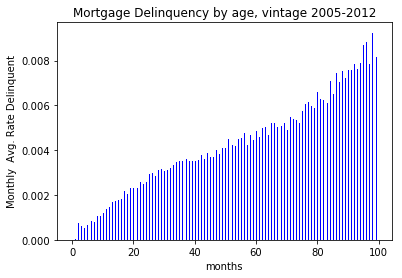

In [40]:
plt.bar(range(100), del_by_age, color='b', align='edge', width=0.32)
plt.ylabel('Monthly  Avg. Rate Delinquent')
plt.title('Mortgage Delinquency by age, vintage 2005-2012')
plt.xlabel('months')
plt.show()

Realistically, this effect is coming in great part from vintage and not loan age per se. Loans dating from before the crisis are considerably more likely to go delinquent.

A regional breakdown:

In [41]:
df['zip region'] = df['postal code'].values // 10000

In [42]:
yearly_del_by_region = []
for i in range(10):
    yearly_dels = []
    slyce = df.loc[df['zip region']==i]
    for y in range(2005,2017):
        y_bin = slyce.loc[slyce['present year']==y]
        rate = 100*12*y_bin.delinquent.astype(int).mean()
        yearly_dels.append(rate)
    yearly_del_by_region.append(yearly_dels)

In [43]:
zip_key = ["PR, NJ, & New England", "NY,PA,DE","Mid-Atlantic","South East","Near Midwest","North Plains","Central Plains","South","Rockies","Pacific"]

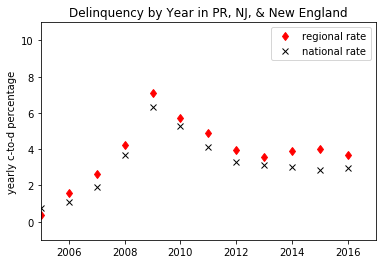

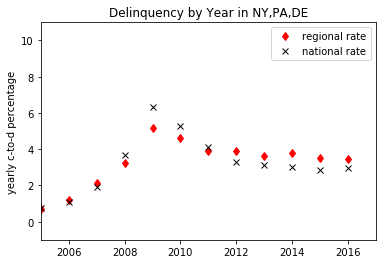

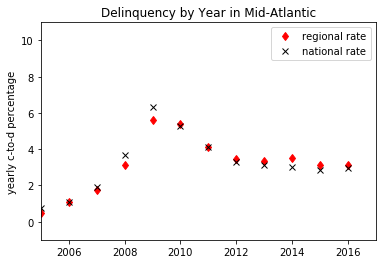

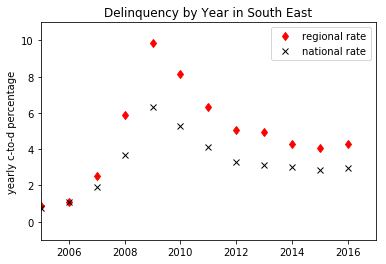

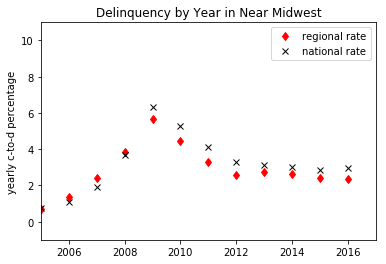

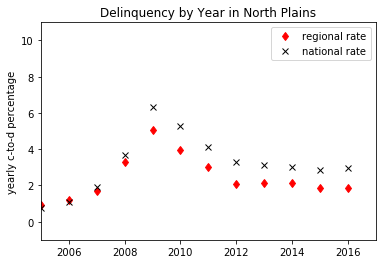

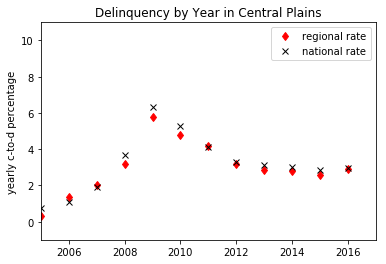

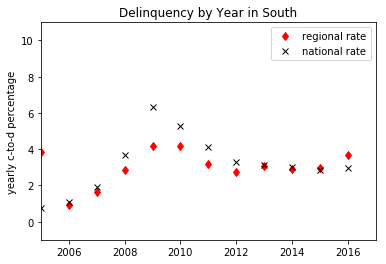

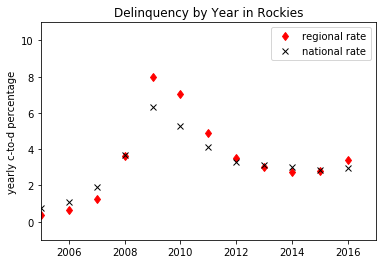

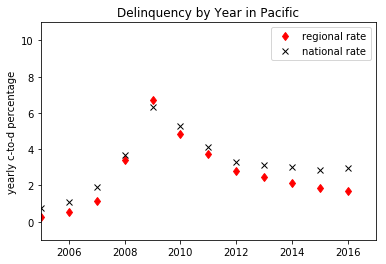

In [44]:
for i in range(10):
    plt.plot(range(2005,2017),yearly_del_by_region[i],'rd',label='regional rate')
    plt.plot(range(2005,2017),delinquency_percent_per_annum,'kx',label='national rate')
    plt.title('Delinquency by Year in '+zip_key[i])
    plt.xlim(2005,2017)
    plt.ylim(-1,11)
    plt.legend(loc=1)
    plt.ylabel('yearly c-to-d percentage')
    plt.show()

It appears that there's not much regional variation in the year-to-year trends of delinquency. 

In [6]:
#### extra features

#### Classifier

#### df['factor'] = df['current actual upb'].values/df['original upb'].values

In [48]:
df['coupon ratio'] = df['current interest rate'].values/df['Rate (Avg)'].values

In [49]:
df_sample = df.sample(frac = 0.2, random_state = 88)

In [50]:
len(df_sample)

4006079

Naturally, sampling the dataset makes the algorithm run faster. There appears to be some point where the volume of points fed into the model overwhelms the computer's RAM. A speedy implementation of the model makes tuning the parameters considerably easier.

After taking a subset of all data points, I further split the data into a training set and a test set. The model's performance (e.g., AUC score) on a test set, which it hasn't seen before, indicates how the model would perform on 'new' data. Comparison of test and training set AUC is a good test of whether the implementation is overfitting or not. 

In [51]:
features = ['loan age', 'credit score', 'unemployment', 'original cltv', 'coupon ratio', 'factor', 'current hpa']
df_train = df_sample.sample(frac = 0.8, random_state = 89)
df_test = df_sample.drop(df_train.index)
X_train = df_train[features]
y_train = df_train['delinquent'].astype(int)
X_test = df_test[features]
y_test = df_test['delinquent'].astype(int)

In [52]:
from sklearn.preprocessing import Imputer
imp = Imputer()
imp.fit(X_train)
X_train = imp.transform(X_train)

imp = Imputer()
imp.fit(X_test)
X_test = imp.transform(X_test)

The Random Forest algorithm is the result of a 'vote' of an ensemble of decision trees that each attempt to classify a dataset into two categories (in this case, loans that will go delinquent and loans that won't). At each 'branch,' a decision tree 'maximally' splits data with respect to a random subset of features, until it has divided the data into a number of 'leaves' from which it calculates probabilities.

Without specifying some parameters that limit the complexity of each decision tree, Random Forests are rather susceptible to overfitting. 

In [54]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 40, min_samples_leaf = 25000, max_leaf_nodes=120, max_depth=15, n_jobs=-1)
rf.fit(X_train, y_train)

#max_leaf_nodes=20, min_samples_leaf=3000

from sklearn import metrics
y_train_score = rf.predict_proba(X_train)[:,1]
y_test_score = rf.predict_proba(X_test)[:,1]
display('Random Forest training set auc vs test set auc is', metrics.roc_auc_score(y_train, y_train_score), metrics.roc_auc_score(y_test, y_test_score))

'Random Forest training set auc vs test set auc is'

0.85758801070778079

0.8484009737342203

Not bad.

In [55]:
d = {}
for i in range(len(features)):
    d[features[i]] = rf.feature_importances_[i]
d

{'coupon ratio': 0.086002083955949854,
 'credit score': 0.56972213602141886,
 'current hpa': 0.0098381535034969096,
 'factor': 0.10884070122280283,
 'loan age': 0.14423197050162967,
 'original cltv': 0.036234320600552865,
 'unemployment': 0.045130634194149179}

The random forest algorithm comes with a direct, natural measure of a feature's importance in a classification problem, namely, how often the algorithm chooses to split the data by a given variable. Here we see that credit score figured in a bit more than half of all branches in the ensemble. 

I plot, for each feature, separated into 20 bins, the actual probability (frequency) of delinquency and estimated probabilities on the training and test sets. 

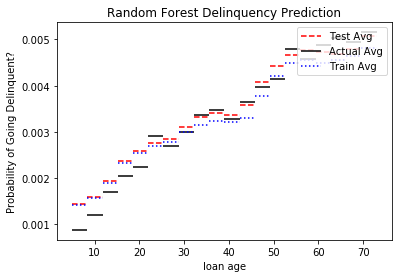

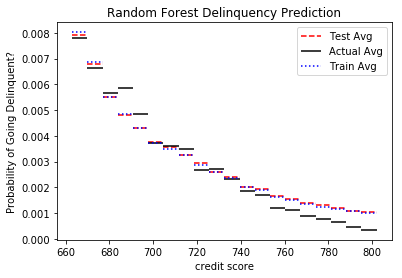

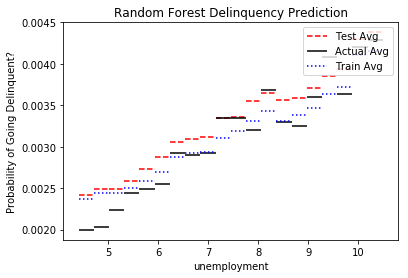

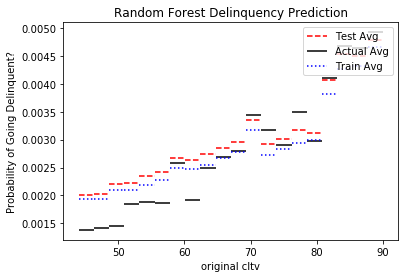

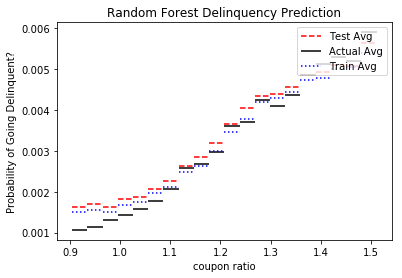

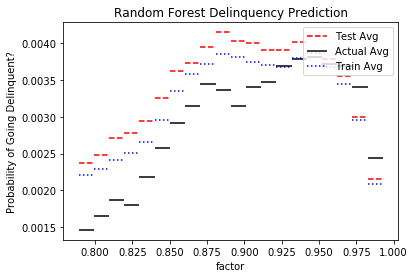

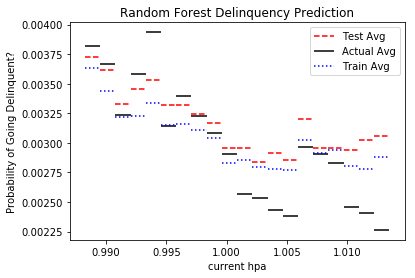

In [54]:
for feature in features:
    floor = df[feature].quantile(0.1)
    ceiling = df[feature].quantile(0.9)
    a = np.linspace(floor, ceiling, 21)
    
    test = df_test[[feature, 'delinquent']]
    test['probs'] = rf.predict_proba(X_test)[:,1]
    
    train = df_train[[feature, 'delinquent']]
    train['probs'] = rf.predict_proba(X_train)[:,1]
    
    sample = df_sample[[feature, 'delinquent']]
    
    def test_prob():
        l = []
        for i in range(len(a) - 1):
            lower = a[i]
            upper = a[i+1]
            bin_i = test.loc[test[feature].between(lower,upper)]
            avg = (bin_i['probs'].values.sum())/len(bin_i['probs'].values)
            l.append(avg)
        return l
    
    def train_prob():
        l = []
        for i in range(len(a) - 1):
            lower = a[i]
            upper = a[i+1]
            bin_i = train.loc[train[feature].between(lower,upper)]
            avg = (bin_i['probs'].values.sum())/len(bin_i['probs'].values)
            l.append(avg)
        return l
    
    def true_prob():
        l = []
        for i in range(len(a)-1):
            lower = a[i]
            upper = a[i+1]
            bin_i = sample.loc[sample[feature].between(lower,upper)]
            s = bin_i['delinquent'].astype(int).mean()
            l.append(s)
        return l
    
    plt.hlines(test_prob(), a[:-1], a[1:], color = 'r', linestyle = "--", label = "Test Avg" )
    plt.hlines(true_prob(), a[:-1], a[1:], label = "Actual Avg")
    plt.hlines(train_prob(),a[:-1], a[1:], color = 'b', linestyle = ':', label = 'Train Avg' )
    plt.legend(loc = 1)
    plt.xlabel(feature)
    plt.title('Random Forest Delinquency Prediction')
    plt.ylabel('Probability of Going Delinquent?')
    plt.show()  

How does a logistic regression with minimal tinkering perform?

In [56]:
import sklearn.linear_model as lr
logit = lr.LogisticRegression()

logit.fit(X = X_train, y = y_train)

display('logit coefficients are: ', logit.coef_)

'logit coefficients are: '

array([[ 0.0207328 , -0.01191677,  0.15165711,  0.01649132,  0.48464182,
         5.35138556, -3.30562063]])

In [57]:
y_train_score = logit.predict_proba(X_train)[:,1]
y_test_score = logit.predict_proba(X_test)[:,1]
display('Logistic regression training set auc vs test set auc is', metrics.roc_auc_score(y_train, y_train_score), metrics.roc_auc_score(y_test, y_test_score))

'Logistic regression training set auc vs test set auc is'

0.85060392087285175

0.84214323388493317

As it turns out, nearly as well. 

I make the same three-way comparison graph for logistic-estimated and actual delinquency probabilities. 

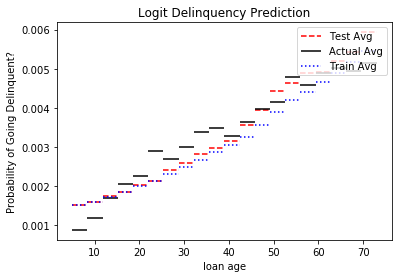

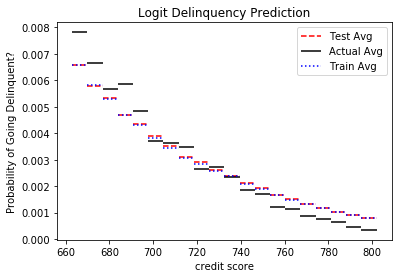

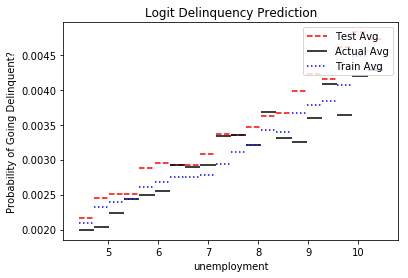

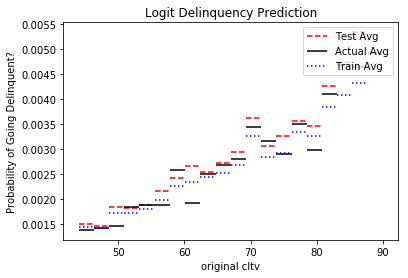

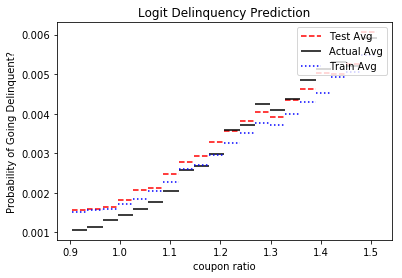

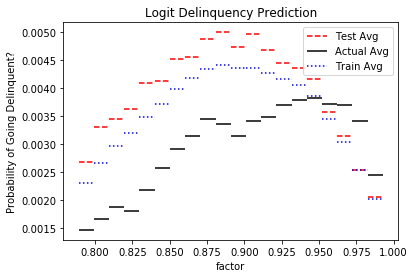

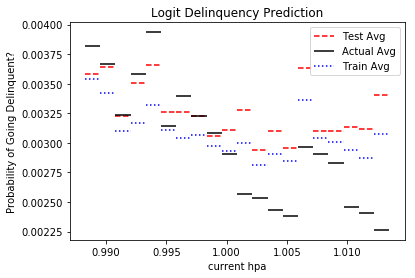

In [58]:
for feature in features:
    floor = df[feature].quantile(0.1)
    ceiling = df[feature].quantile(0.9)
    a = np.linspace(floor, ceiling, 21)
    
    test = df_test[[feature, 'delinquent']]
    test['probs'] = logit.predict_proba(X_test)[:,1]
    
    train = df_train[[feature, 'delinquent']]
    train['probs'] = logit.predict_proba(X_train)[:,1]
    
    sample = df_sample[[feature, 'delinquent']]
    
    def test_prob():
        l = []
        for i in range(len(a) - 1):
            lower = a[i]
            upper = a[i+1]
            bin_i = test.loc[test[feature].between(lower,upper)]
            avg = (bin_i['probs'].values.sum())/len(bin_i['probs'].values)
            l.append(avg)
        return l
    
    def train_prob():
        l = []
        for i in range(len(a) - 1):
            lower = a[i]
            upper = a[i+1]
            bin_i = train.loc[train[feature].between(lower,upper)]
            avg = (bin_i['probs'].values.sum())/len(bin_i['probs'].values)
            l.append(avg)
        return l
    
    def true_prob():
        l = []
        for i in range(len(a)-1):
            lower = a[i]
            upper = a[i+1]
            bin_i = sample.loc[sample[feature].between(lower,upper)]
            s = bin_i['delinquent'].astype(int).mean()
            l.append(s)
        return l
    
    plt.hlines(test_prob(), a[:-1], a[1:], color = 'r', linestyle = "--", label = "Test Avg" )
    plt.hlines(true_prob(), a[:-1], a[1:], label = "Actual Avg")
    plt.hlines(train_prob(),a[:-1], a[1:], color = 'b', linestyle = ':', label = 'Train Avg' )
    plt.legend(loc = 1)
    plt.xlabel(feature)
    plt.title('Logit Delinquency Prediction')
    plt.ylabel('Probability of Going Delinquent?')
    plt.show()  


  

Conclusion: At a glance, it seems that a logistical regression and random forest perform nearly equally on the delinquency problem. However, I've found that on a larger data sample (i.e., 50% of all entries rather than 20%), a random forest (with appropriate parameters) begins to outperform a logistic regression. This advantage is offset by the fact that the random forest starts slowing down excessively on large training sets.

There is no obvious measure of feature importance in a logistic regression, unlike in a random forest. (Though normlalizing the variables to the same scale and considering coefficients should solve this issue.) The principal trade off between a RF classification and logit is where the work comes in. Logit seems to benefit mainly from feature-engineering, responding poorly to non-linear/'fainter' variables. (Compare RF's response to factor and HPA, which adheres more closely to actual probabilities than logit.) Conversely, optimizing a random forest requires a lot of tinkering with parameters, which can become tedious/inefficient if the algorithm itself runs slowly.